# Accuracy of adaptive GPA on artificial lattices

This notebook showcases (a subset of) the adaptive GPA and unit cell averaging possibilities of pyGPA using artificial data of an hexagonal lattice.

In [1]:
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.io import imread

import colorcet

from skimage.feature import peak_local_max
import scipy.ndimage as ndi

from dask.distributed import Client, LocalCluster

from moisan2011 import per
from pyGPA.phase_unwrap import phase_unwrap
from pyGPA.imagetools import fftplot, gauss_homogenize2, gauss_homogenize3
from pyGPA.mathtools import wrapToPi, standardize_ks
import pyGPA.geometric_phase_analysis as GPA

from latticegen import hexlattice_gen_singularity, hexlattice_gen, generate_ks, hexlattice_gen_fast
%matplotlib inline

In [2]:
cluster = LocalCluster(n_workers=1, threads_per_worker=12, memory_limit='8GB')  
client = Client(cluster)
client

/home/tobias/anaconda3/envs/pyGPA-cupy/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35575 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33059' processes=1 threads=12, memory=7.45 GiB>

## Generate test data

To explore the various aspects of GPA, adaptive GPA and unit cell averaging, we first generate a dataset to test various aspects on using `latticegen`.
This dataset will include a known deformation and added noise.

In [3]:
S = 250  # Half size of visualization in pixels. Optimized for interactive rendering on mybinder.
r_k = 0.2 
a_0 = 0.246  # Lattice constant of graphene in nm



Text(0.5, 1.0, '$u_x$')

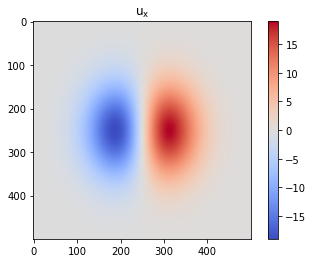

In [4]:
# For the deformation we take a reasonably smooth squeeze in the x direction
xp, yp = da.meshgrid(np.arange(-S,S), np.arange(-S,S), indexing='ij')
xshift = 0.5*xp*np.exp(-0.5 * ((xp/(2*S/8))**2 + 1.2*(yp/(2*S/6))**2))
plt.imshow(xshift.T.compute(), cmap='coolwarm')
plt.colorbar()
plt.title('$u_x$')

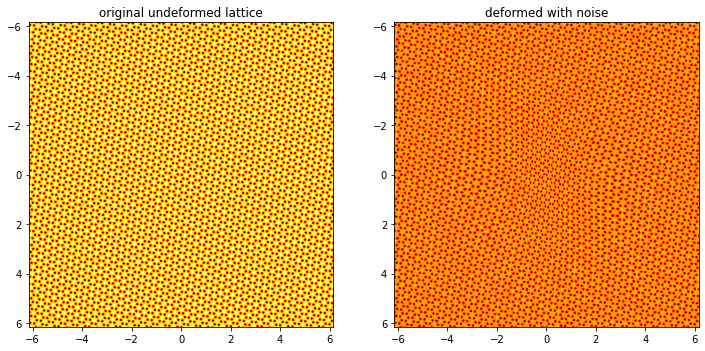

In [5]:
r_k = 0.1
xi0 = 7.0
psi= 0.0
kappa=1.001

order = 3
fig, ax = plt.subplots(figsize=[12,6], ncols=2)
original = hexlattice_gen(r_k, xi0, order, size=2*S, kappa=kappa, psi=psi).compute()
ax[0].imshow(original.T, 
             cmap='cet_fire_r',
            extent=[-S*r_k*a_0, S*r_k*a_0, S*r_k*a_0, -S*r_k*a_0])
ax[0].set_title('original undeformed lattice')
u_ori = np.stack((xshift,np.zeros_like(xshift)), axis=0)
deformed_ori = hexlattice_gen(r_k, xi0, order, 2*S, kappa=kappa, psi=psi,
                              shift=u_ori
                             ).compute()
noise = ndi.filters.gaussian_filter(50*np.random.normal(size=deformed_ori.shape), sigma=0.5)
deformed = deformed_ori + noise
ori_ks = generate_ks(r_k, xi0, kappa=kappa, psi=psi)[:-1]
ax[1].imshow(deformed.T, 
             cmap='cet_fire_r',
            extent=[-S*r_k*a_0, S*r_k*a_0, S*r_k*a_0, -S*r_k*a_0])
ax[1].set_title('deformed with noise');
#plt.savefig(os.path.join('accuracyplots', 'start.png'))

## Extracting k-vectors

To start applying GPA, we need some reference vectors to create the reference lattice with respect to which the phase differences and therefore in the end the deformations will be computed. pyGPA has a `extract_primary_ks` function to extract those:

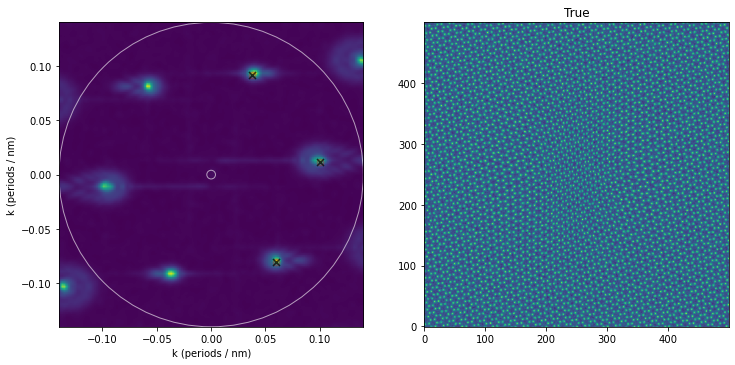

In [6]:
pks,_ = GPA.extract_primary_ks(deformed, pix_norm_range=(2,70), plot=True)

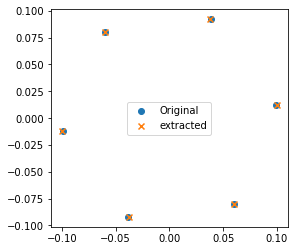

In [7]:
plt.scatter(*ori_ks.T, label='Original')
plt.scatter(*np.concatenate([pks,-pks]).T, marker='x', label='extracted')
plt.gca().set_aspect('equal')
plt.legend();

In [8]:
# Despite the good agreement between extracted and original,
# We take the exact original k-vectors here to enable comparisons
pks = ori_ks[:3]

## Extract deformation

Using these k-vectors and picking a value for the width of the gaussian convolution window `sigma`, we can directly use the top-level convenience function `GPA.extract_displacement_field` to extract a displacement field and compare this to the 'true deformation.

In [9]:
sigma = 10
dr = 2*sigma
unew = GPA.extract_displacement_field(deformed_ori, pks, sigma=sigma)
udiff = unew + u_ori  # Yes, there is a mysterious minus sign.

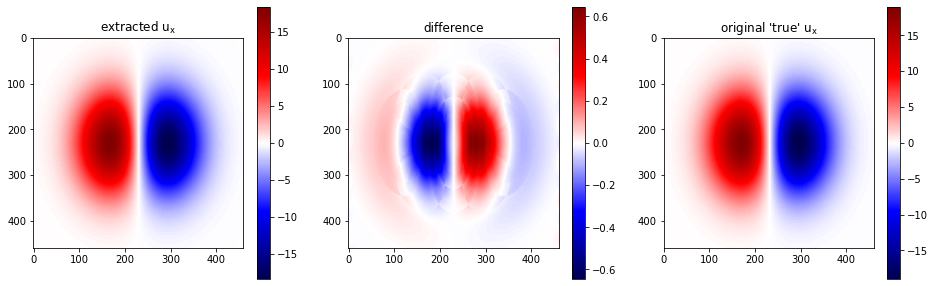

In [10]:
fig,ax = plt.subplots(ncols=3, figsize=[16,5])
im = ax[0].imshow(unew[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[0])
ax[0].set_title('extracted $u_x$')
im = ax[1].imshow(udiff[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[1])
ax[1].set_title("difference")
im = ax[2].imshow(-u_ori[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[2])
ax[2].set_title("original 'true' $u_x$");

## Deconvolution

Although the extracted `u` is close to the true one, the difference plot reveals a remarkable correlation between the error and the original. The GPA algorithm inherently introduces a convolution with the gaussian window function. Luckily, this convolution kernel is exactly known! Let's check if that is reflected in the extracted `u` by comparing to a convoluted original `u`.

In [11]:
X = np.fft.fft2(u_ori)
u_conv = np.fft.ifft2(ndi.fourier_gaussian(X, sigma=sigma)).real
udiff2 = unew + u_conv

Text(0.5, 1.0, 'gaussian smoothed original $u_x$')

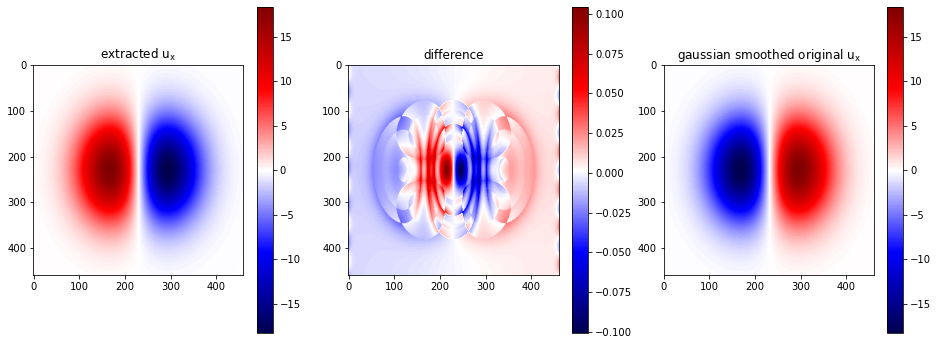

In [12]:
fig,ax = plt.subplots(ncols=3, figsize=[16,6])

im = ax[0].imshow(unew[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[0])
ax[0].set_title('extracted $u_x$')
im = ax[1].imshow(udiff2[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[1])
ax[1].set_title("difference")
im = ax[2].imshow(u_conv[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[2])
ax[2].set_title('gaussian smoothed original $u_x$')

That difference is much smaller! Therefore, if the data is smooth enough, we can _deconvolve_ the extracted `u` to better approximate the true `u`:

In [13]:
u_deconv = GPA.gaussian_deconvolve(unew, sigma=sigma, balance=1e3)  #Thin wrapper around skimage.restoration.wiener
udiff3 = u_deconv + u_ori

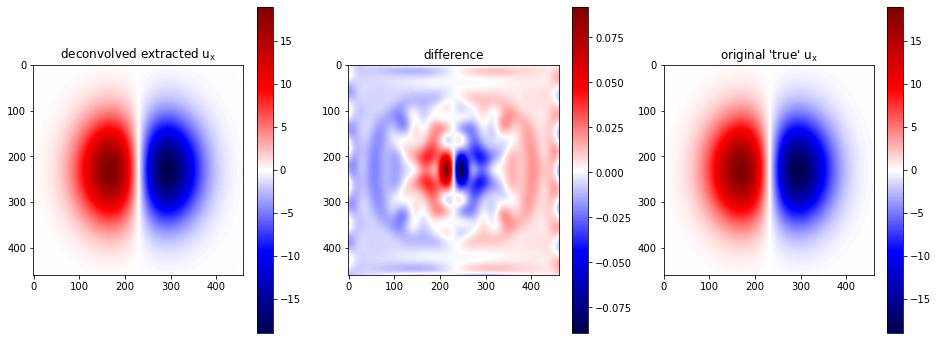

In [14]:
fig,ax = plt.subplots(ncols=3, figsize=[16,6])
im = ax[0].imshow(u_deconv[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[0])
ax[0].set_title('deconvolved extracted $u_x$')
im = ax[1].imshow(udiff3[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[1])
ax[1].set_title("difference")
im = ax[2].imshow(-u_ori[0,dr:-dr,dr:-dr].T, cmap='seismic')
plt.colorbar(im, ax=ax[2])
ax[2].set_title("original 'true' $u_x$");

This is much better, with a maximum error of less then one tenth of a pixel.

## On adaptive GPA

We have seen that we can extract deformation fields `u` using pyGPA, bu let's now look under the hood and check what is happening and what the difference between adaptive GPA and regular GPA is.
Adaptive GPA uses not 3 reference $k$-vectors, but checks for the maximum amplitude/weight of the spatial lock-in signal for a range of vectors around each reference $k$-vector. This is calculated by `wfr<xxxx>` functions.

To visualize what is happening we will reconstruct the local k-vectors and visualize the FFT by plotting a 2D histogram of those. 

In [15]:
gs = []
kw = np.linalg.norm(pks, axis=1).mean() / 2.5
sigma = int(np.ceil(1/np.linalg.norm(pks, axis=1).min()))
kstep = kw/4
for pk in pks:
    g = GPA.wfr2_grad_opt(deformed-deformed.mean(), sigma, pk[0]*1., pk[1]*1., kw=kw, kstep=kstep)
    gs.append(g)

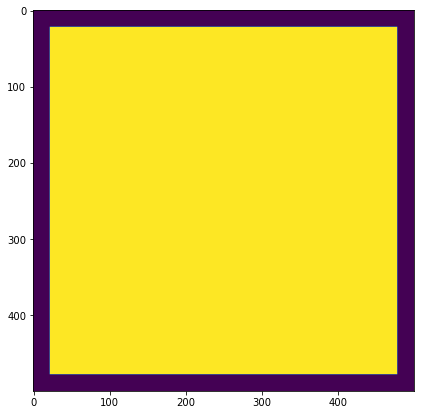

In [16]:
# Mask to ignore values influenced by the edge.
fig, axs = plt.subplots(figsize=[7,7])
mask = np.zeros_like(deformed, dtype=bool)
dr = 2*sigma
mask[dr:-dr,dr:-dr] = 1.

axs.imshow(mask.T)

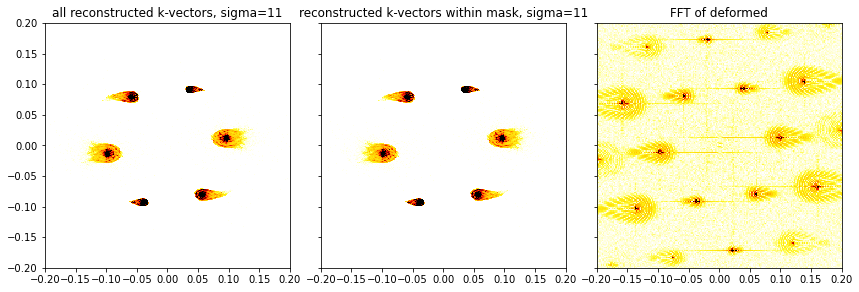

In [17]:
wadvs = []
for i in range(3):
    phase = np.angle(GPA.optGPA(deformed-deformed.mean(), pks[i], sigma))
    gphase = np.stack(wrapToPi(np.array(np.gradient(phase))*2)/4/np.pi)
    w = gphase - pks[i,:, None, None]
    wadvs.append(w)
wadvs = np.stack(wadvs)

wxs = np.concatenate([wadvs[:,0], -wadvs[:,0]])
wys = np.concatenate([wadvs[:,1], -wadvs[:,1]])
p,_ =  per(deformed - deformed.mean(), inverse_dft=False)
fftim = np.abs(np.fft.fftshift(p))
r = 0.2
fig, axs = plt.subplots(ncols=3,figsize=[12,4], sharex=True, sharey=True)
axs[0].hist2d(wxs.ravel(),
           wys.ravel(),
           bins=500, cmap='cet_fire_r',vmax=200, range=[(-r,r),(-r,r)])
axs[0].set_aspect('equal')

axs[1].hist2d(wxs.ravel()[np.stack([mask]*6).ravel()], 
           wys.ravel()[np.stack([mask]*6).ravel()], 
           bins=500, cmap='cet_fire_r',vmax=200, range=[(-r,r),(-r,r)])
axs[1].set_aspect('equal')
fftplot(fftim, ax=axs[2], pcolormesh=False, vmax=np.quantile(fftim, 0.9999),
             vmin=np.quantile(fftim, 0.01), cmap='cet_fire_r', interpolation='none', origin='lower')
axs[0].set_title(f'all reconstructed k-vectors, sigma={sigma}')
axs[1].set_title(f'reconstructed k-vectors within mask, sigma={sigma}')
axs[2].set_title(f'FFT of deformed')
axs[0].set_ylim(-r,r)
axs[0].set_xlim(-r,r)
plt.tight_layout()

Although it is clear that the reconstructed k-vectors correspond to the FFT, regular GPA can only reconstruct k-vectors close to the reference vector, meaning the tails of the peaks do not reconstruct correctly. Now we compare to extended GPA, where those tails are reconstructed, and also plot the corresponding measured phases.

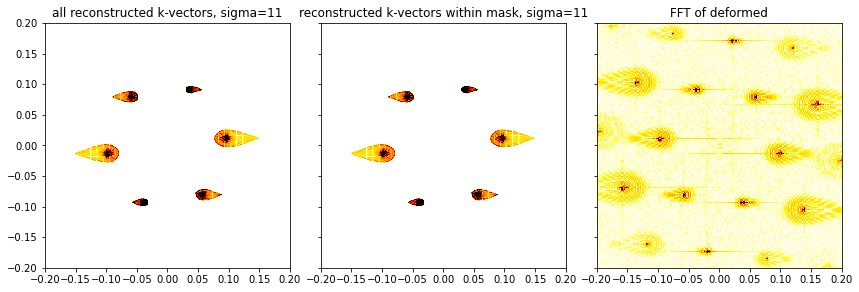

In [18]:
wadvs = []
for i in range(3):
    phase = np.angle(gs[i]['lockin'])
    gphase = np.moveaxis(gs[i]['grad'],-1,0)/2/np.pi
    w = gphase + pks[i,:, None, None]
    wadvs.append(w)
wadvs = np.stack(wadvs)

wxs = np.concatenate([wadvs[:,0], -wadvs[:,0]])
wys = np.concatenate([wadvs[:,1], -wadvs[:,1]])
p,_ =  per(deformed-deformed.mean(), inverse_dft=False)
fftim = np.abs(np.fft.fftshift(p))

fig, axs = plt.subplots(ncols=3,figsize=[12,4], sharex=True, sharey=True)
axs[0].hist2d(wxs.ravel(),
           wys.ravel(),
           bins=500, cmap='cet_fire_r',vmax=200, range=[(-r,r),(-r,r)])#, ax=axs[0]);
axs[0].set_aspect('equal')
axs[1].hist2d(wxs.ravel()[np.stack([mask]*6).ravel()], 
           wys.ravel()[np.stack([mask]*6).ravel()], 
           bins=500, cmap='cet_fire_r',vmax=200, range=[(-r,r),(-r,r)])#, ax=axs[0]);
axs[1].set_aspect('equal')
fftplot(fftim, ax=axs[2], pcolormesh=False, vmax=np.quantile(fftim, 0.9999),
             vmin=np.quantile(fftim, 0.01), cmap='cet_fire_r', interpolation='none')
axs[0].set_title(f'all reconstructed k-vectors, sigma={sigma}')
axs[1].set_title(f'reconstructed k-vectors within mask, sigma={sigma}')
axs[2].set_title(f'FFT of deformed')
axs[0].set_ylim(-0.2,0.2)
axs[0].set_xlim(-0.2,0.2)
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'extendedGPA.png'))

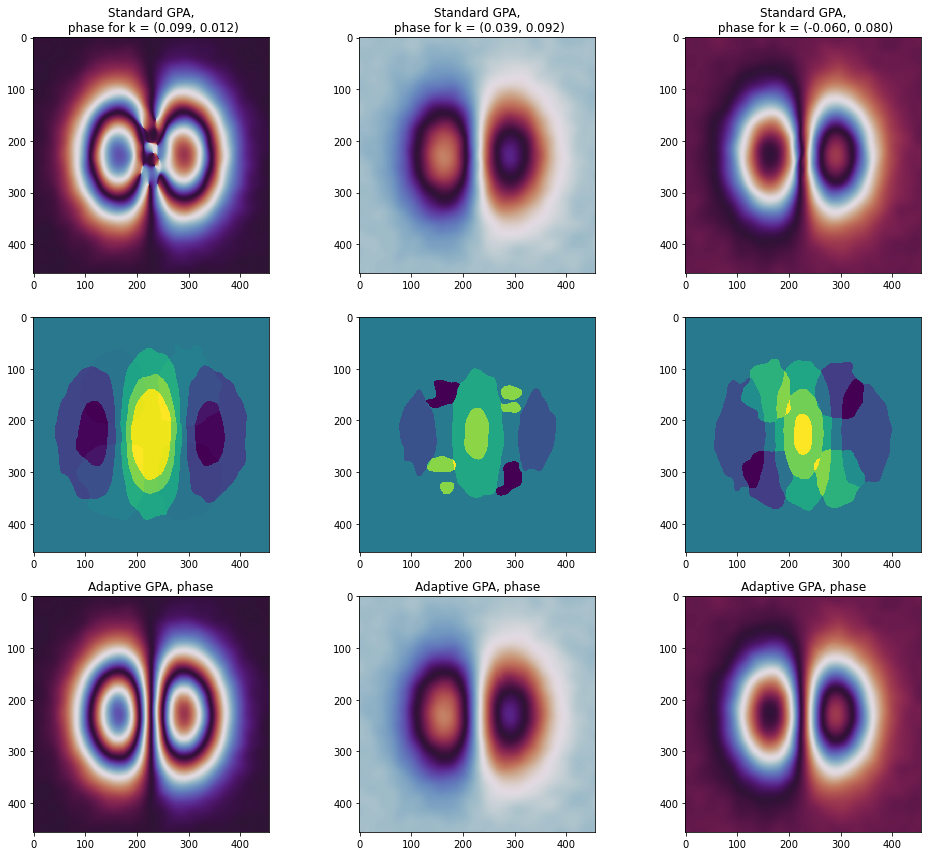

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=[14,12])
xx, yy = xp, yp
for i in range(len(gs)):
    dx =  pks[i][0] - gs[i]['w'][0]
    dy = pks[i][1] - gs[i]['w'][1]
    phase = np.exp(1j*np.angle(gs[i]['lockin']))
    ori_phase = GPA.optGPA(deformed-deformed.mean(), pks[i], sigma)
    im = axs[0,i].imshow(np.angle(ori_phase)[dr:-dr,dr:-dr].T,
                         cmap='twilight', interpolation='none')
    
    im = axs[1,i].imshow(np.where(True, np.sqrt(gs[i]['w'][0]**2 + gs[i]['w'][1]**2), np.nan)[dr:-dr,dr:-dr].T,
                         interpolation='none')
    im = axs[2,i].imshow(np.where(mask, np.angle(phase), np.nan)[dr:-dr,dr:-dr].T,
                         cmap='twilight', interpolation='none')
    axs[0,i].set_title(f"Standard GPA,\n phase for k = ({pks[i][0]:.3f}, {pks[i][1]:.3f})")
    axs[2,i].set_title("Adaptive GPA, $|k-k_{ref}|$")
    axs[2,i].set_title("Adaptive GPA, phase")
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'phases_k_abs_classical.png'))

From the extracted GPA phases we once again reconstruct a deformation field, using the GPA amplitudes as weights

In [20]:
phases = np.stack([np.angle(g['lockin']) for g in gs])
#diff = (phases[1]-phases[0])[dr:-dr,dr:-dr]
#phases[0] = wrapToPi(phases[0] + wrapToPi(diff).mean())
maskzero = 0.000001
weights = np.stack([np.abs(g['lockin']) for g in gs])*(mask+maskzero)

grads = np.stack([g['grad'] for g in gs])


unew = GPA.reconstruct_u_inv_from_phases(pks, phases, weights)


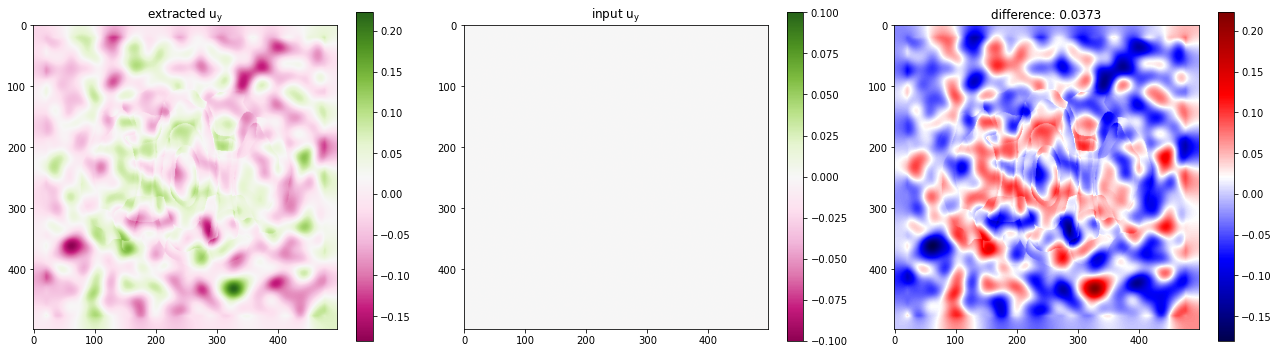

In [21]:
dr=1
fi, ax = plt.subplots(ncols=3, figsize=[18,5])
im = ax[0].imshow(unew[1][dr:-dr,dr:-dr].T, cmap='PiYG', 
                  #vmax=np.abs(u_ori[1]).max(), vmin=-np.abs(u_ori[1]).max()
                 )
plt.colorbar(im, ax=ax[0])
ax[0].set_title('extracted $u_y$')
im = ax[1].imshow(-u_ori[1][dr:-dr,dr:-dr].T, cmap='PiYG',
                 #vmax=np.abs(u_ori[1]).max(), vmin=-np.abs(u_ori[1]).max()
                 )
plt.colorbar(im, ax=ax[1])
ax[1].set_title('input $u_y$')
diff = ((unew[1]+u_ori[1])[dr:-dr,dr:-dr])
im = ax[2].imshow(diff.T, cmap='seismic')
ax[2].set_title(f'difference: {float(np.abs(diff).mean()):.4f}')
plt.colorbar(im)
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'u_y.png'))

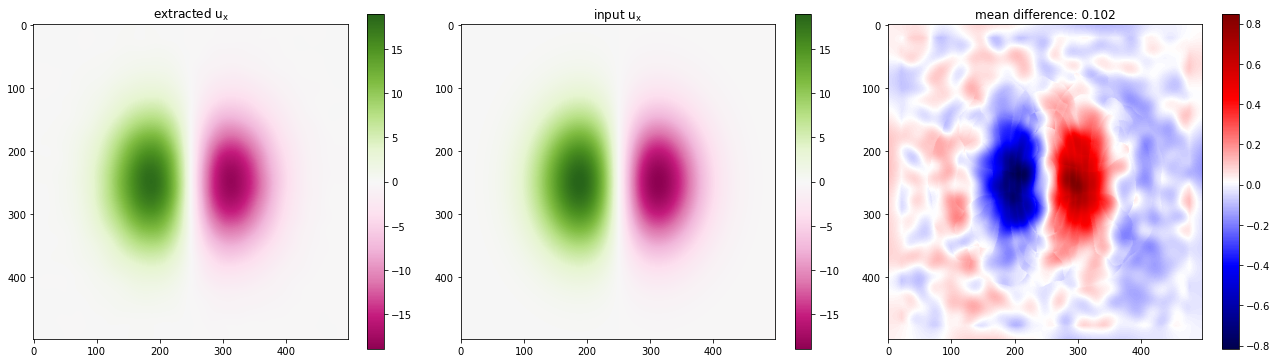

In [22]:
fi, ax = plt.subplots(ncols=3, figsize=[18,5])
im = ax[0].imshow(unew[0][dr:-dr,dr:-dr].T, cmap='PiYG', 
                  vmax=xshift.max(), vmin=-xshift.max()
                 )
plt.colorbar(im, ax=ax[0])
ax[0].set_title('extracted $u_x$')
im = ax[1].imshow(-u_ori[0][dr:-dr,dr:-dr].T, cmap='PiYG',
                 vmax=xshift.max(), vmin=-xshift.max()
                 )
plt.colorbar(im, ax=ax[1])
ax[1].set_title('input $u_x$')
diff = ((unew[0]+u_ori[0])[dr:-dr,dr:-dr])
im = ax[2].imshow(diff.T, cmap='seismic')
ax[2].set_title(f'mean difference: {float(np.abs(diff).mean()):.3f}')
plt.colorbar(im)
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'u_x.png'))

## Lawler-Fujita (distortion correction)

Using the extracted deformation field `u`, it is now possible to correct for this distortion, a procedure known in STM as Lawler-Fujita correction.

In [23]:
reconstructed = GPA.undistort_image(deformed, -unew) # Remember the minus sign compared to the original u? Here it is  again...

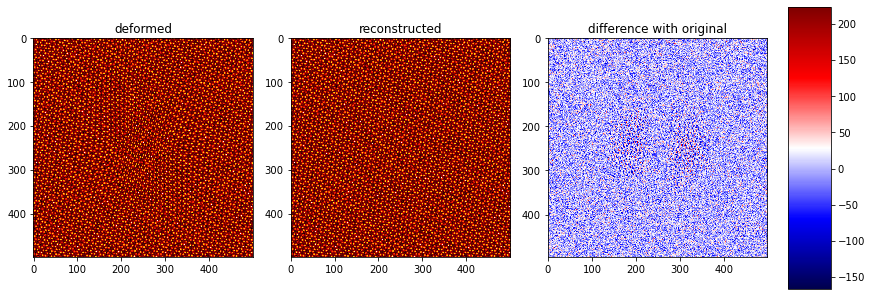

In [24]:
fig,ax = plt.subplots(ncols=3,figsize=[12,4], constrained_layout=True)
ax[1].imshow(reconstructed.T, vmax=np.quantile(reconstructed, 0.999),
             vmin=np.quantile(reconstructed, 0.001),
           cmap='cet_fire', interpolation='none')
ax[1].set_title('reconstructed')
im = ax[0].imshow(deformed.T, vmax=np.quantile(deformed, 0.999),
             vmin=np.quantile(deformed, 0.001),
          cmap='cet_fire', interpolation='none')
#plt.colorbar(im, ax=ax[0])
ax[0].set_title('deformed')
im = ax[2].imshow((reconstructed-original)[dr:-dr,dr:-dr].T, 
           cmap='seismic', interpolation='none')
plt.colorbar(im, ax=ax)
ax[2].set_title('difference with original')
#plt.savefig(os.path.join('accuracyplots', 'lawler_fujita.png'))

In [25]:
reconstructed2 = GPA.undistort_image(deformed, -u_deconv)

Text(0.5, 1.0, 'difference with original')

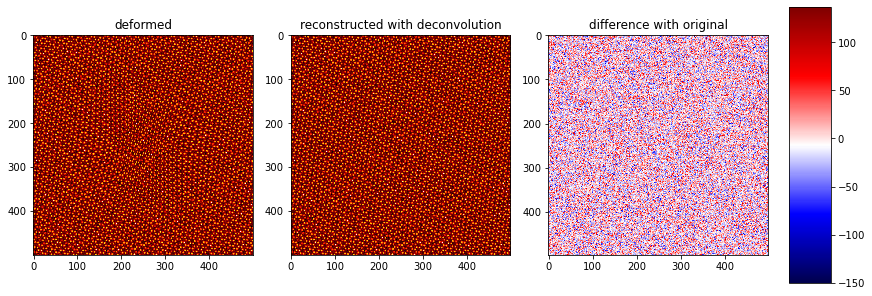

In [26]:
fig,ax = plt.subplots(ncols=3,figsize=[12,4], constrained_layout=True)
ax[1].imshow(reconstructed2.T, vmax=np.quantile(reconstructed2, 0.999),
             vmin=np.quantile(reconstructed2, 0.001),
           cmap='cet_fire', interpolation='none')
ax[1].set_title('reconstructed with deconvolution')
im = ax[0].imshow(deformed.T, vmax=np.quantile(deformed, 0.999),
             vmin=np.quantile(deformed, 0.001),
          cmap='cet_fire', interpolation='none')
#plt.colorbar(im, ax=ax[0])
ax[0].set_title('deformed')
im = ax[2].imshow((reconstructed2-original)[dr:-dr,dr:-dr].T, 
           cmap='seismic', interpolation='none')
plt.colorbar(im, ax=ax)
ax[2].set_title('difference with original')

As an alternative error check, we can use an optical flow algorithm from scikit image to check how the reconstructed image can be deformed to obtain the original image

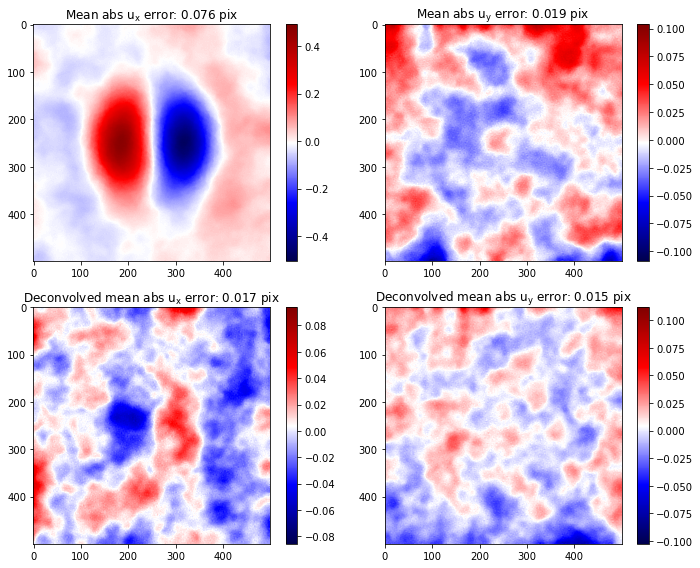

In [27]:
from skimage.registration import optical_flow_tvl1

u,v = optical_flow_tvl1(original, reconstructed, attachment=0.001, tightness=0.2, num_iter=20)
u2,v2 = optical_flow_tvl1(original, reconstructed2, attachment=0.001, tightness=0.2, num_iter=20)
fi, ax = plt.subplots(ncols=2, nrows=2, figsize=[10,8])
ax = ax.T
im = ax[0,0].imshow(u.T, cmap='seismic')
ax[0,0].set_title(f'Mean abs $u_x$ error: {np.abs(u).mean():.3f} pix')
plt.colorbar(im, ax=ax[0,0])
im = ax[1,0].imshow(v.T, cmap='seismic')
ax[1,0].set_title(f'Mean abs $u_y$ error: {np.abs(v).mean():.3f} pix')
#ax[1,0].set_title(np.abs(v).mean())
plt.colorbar(im, ax=ax[1,0])
im = ax[0,1].imshow(u2.T, cmap='seismic')
#ax[0,1].set_title(np.abs(u2).mean())
ax[0,1].set_title(f'Deconvolved mean abs $u_x$ error: {np.abs(u2).mean():.3f} pix')
plt.colorbar(im, ax=ax[0,1])
im = ax[1,1].imshow(v2.T, cmap='seismic')
#ax[1,1].set_title(np.abs(v2).mean())
ax[1,1].set_title(f'Deconvolved mean abs $u_y$ error: {np.abs(v2).mean():.3f} pix')
plt.colorbar(im, ax=ax[1,1])
plt.tight_layout()

## Unit cell averaging
To squeeze out as much information about the consituting unit cell and further improve the image, we can perform unit cell averaging:

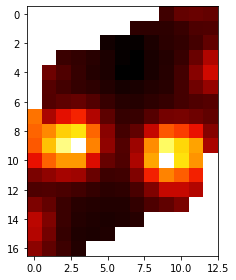

In [28]:
import pyGPA.unit_cell_averaging as uc

z = 1

plt.imshow(uc.unit_cell_average(reconstructed, pks[:2], u=np.zeros_like(reconstructed), z=z).T,
          cmap='cet_fire')#, vmax=20)
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'unitcellaverage_z=1.png'))

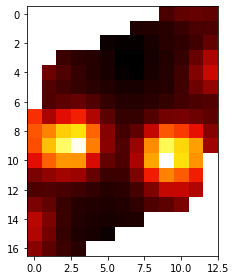

In [29]:
zoomoriginal = hexlattice_gen(r_k/z, xi0, order, size=2*S, kappa=kappa, psi=psi).compute()
ucelorig = uc.unit_cell_average(zoomoriginal, pks[:2]/z, z=z)
plt.imshow(ucelorig.T, cmap='cet_fire')
plt.tight_layout()


Although that looks pretty similar, we would like to extract more information. We can scale up the unit cell, and use a drizzle like averaging in the unit cell to reconstruct a higher resolution image of the unit cell. The maximum useful zoom factor depends on a lot of parameters, including but not limited to the number of unit cells in the dataset, the noise level, the maximum deformation, the point spread function of the instrument, etc...

In [30]:
z = 5
ucellim = uc.unit_cell_average(deformed, pks[:2], u=-u_deconv, z=z)

ucelorig = uc.unit_cell_average(original, pks[:2], z=z)

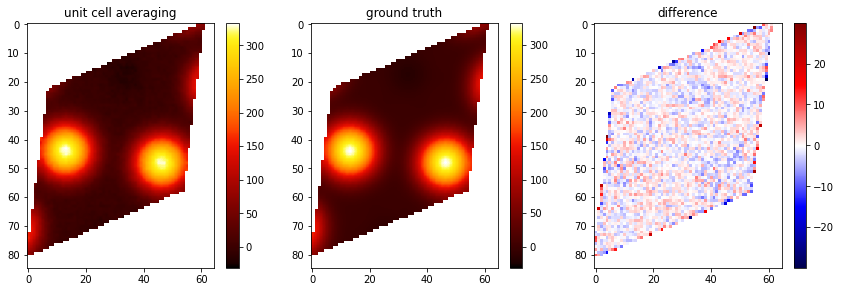

In [31]:
fig, ax = plt.subplots(ncols=3, figsize=[12,4])
im = ax[0].imshow(ucellim.T, cmap='cet_fire')#, vmax=20)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('unit cell averaging')
ax[1].set_title('ground truth')
ax[2].set_title('difference')
im = ax[1].imshow(ucelorig.T, cmap='cet_fire', vmin=np.nanmin(ucellim))#, vmax=20)
plt.colorbar(im, ax=ax[1])
diff = ucellim - ucelorig
im = ax[2].imshow(diff.T, 
                  vmax=np.nanquantile(np.abs(diff), 0.999), vmin=-np.nanquantile(np.abs(diff), 0.999), 
                  cmap='seismic', interpolation='none')#, vmax=20)
plt.colorbar(im, ax=ax[2])
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'unitcellaverage_z=5.png'))

In addition, we can now project back this averaged unit cell to the deformed image to compare...

In [32]:
uc_averaged = uc.expand_unitcell(ucellim, pks[:2], (500,500), u=-u_deconv, z=z)

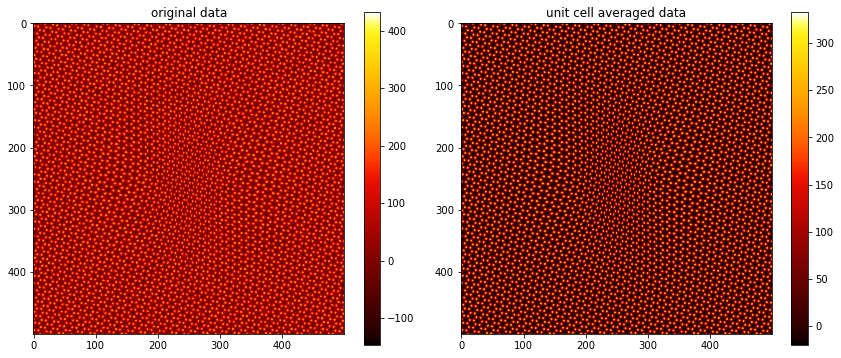

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=[12,5])
im = ax[0].imshow(deformed.T, cmap='cet_fire')
ax[0].set_title('original data')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(uc_averaged.T, cmap='cet_fire')
ax[1].set_title('unit cell averaged data')
plt.colorbar(im, ax=ax[1])
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'unitcellaverage_expanded.png'))

And compare this to the original data without the added noise:

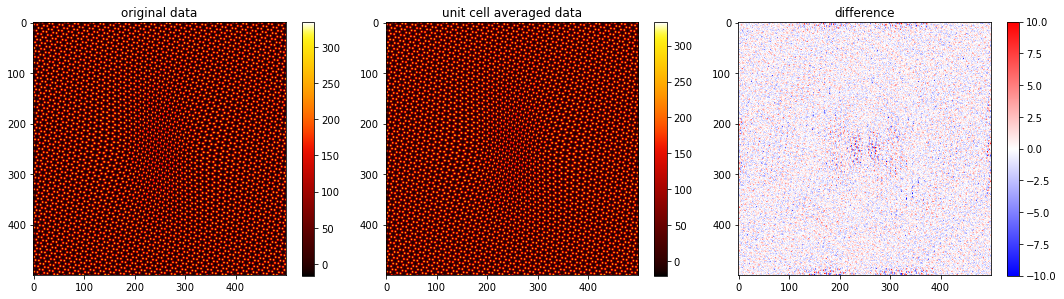

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=[15,4])
im = ax[0].imshow(deformed_ori.T, cmap='cet_fire')
ax[0].set_title('original data')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(uc_averaged.T, cmap='cet_fire')
ax[1].set_title('unit cell averaged data')
plt.colorbar(im, ax=ax[1])
diff = (deformed_ori - uc_averaged)
im = ax[2].imshow(diff.T, cmap='bwr', vmax=10, vmin=-10)
ax[2].set_title('difference')
plt.colorbar(im, ax=ax[2])
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'unitcellaverage_with_original.png'))

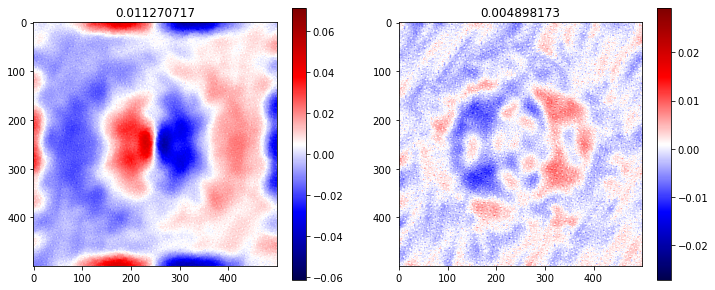

In [35]:
#Optical flow again...

u,v = optical_flow_tvl1(deformed_ori, uc_averaged, attachment=0.001, tightness=0.2, num_iter=20)
fi, ax = plt.subplots(ncols=2, figsize=[12,5])
im = ax[0].imshow(u.T, cmap='seismic')
ax[0].set_title(np.abs(u).mean())
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(v.T, cmap='seismic')
ax[1].set_title(np.abs(v).mean())
plt.colorbar(im, ax=ax[1])

As a final check we can compare unit cell averaged data using the true deformation `u_ori` with the original data (removing the GPA errors from the equation).

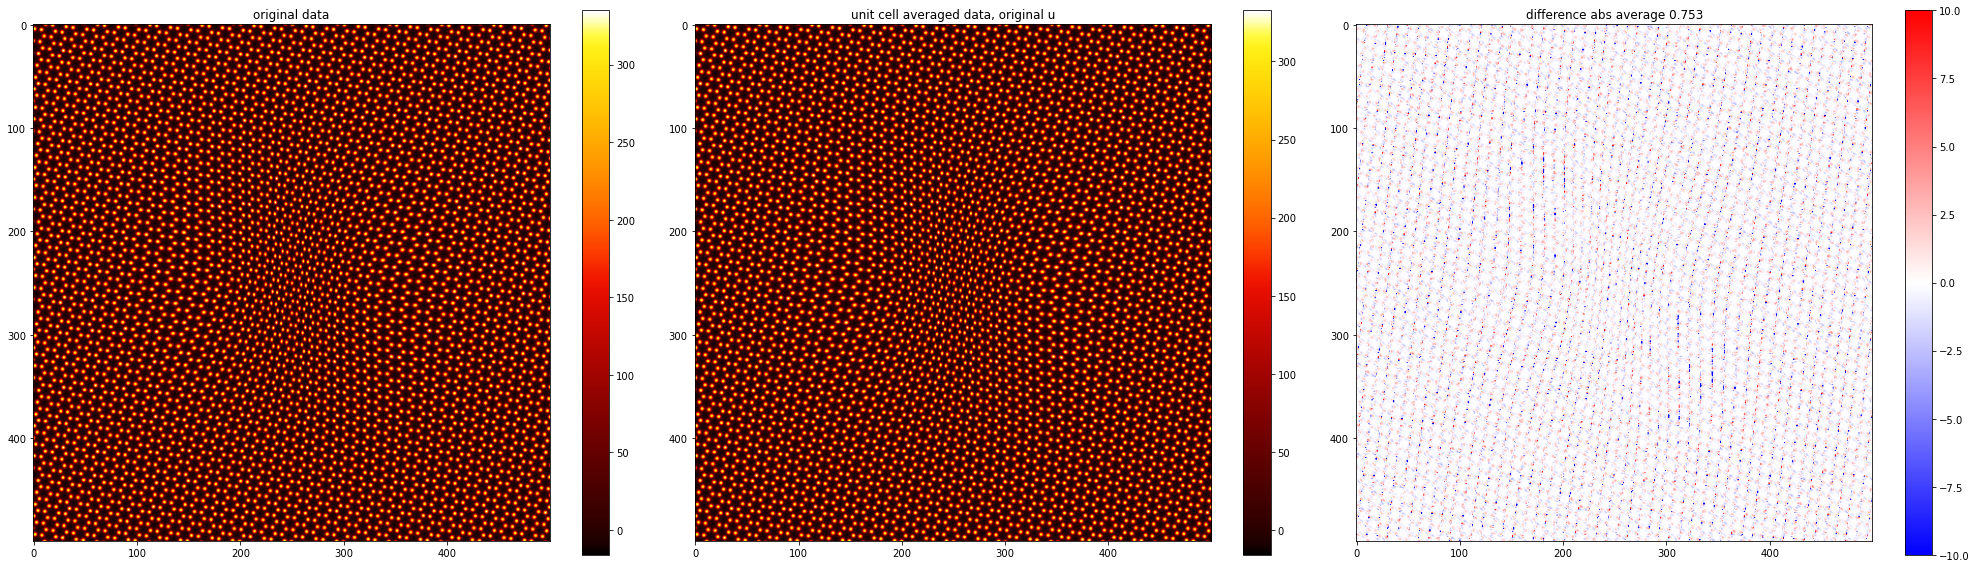

In [36]:
ucellim = uc.unit_cell_average(deformed_ori, pks[:2], u=u_ori.compute(), z=z)
uc_averaged_uori = uc.expand_unitcell(ucellim, pks[:2], (500,500), u=u_ori.compute(), z=z)
fig, ax = plt.subplots(ncols=3, figsize=[28,8])
im = ax[0].imshow(deformed_ori.T, cmap='cet_fire')
ax[0].set_title('original data')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(uc_averaged_uori.T, cmap='cet_fire')
ax[1].set_title('unit cell averaged data, original u')
plt.colorbar(im, ax=ax[1])
diff = (deformed_ori - uc_averaged_uori)
im = ax[2].imshow(diff.T, cmap='bwr', vmin=-10, vmax=10)
ax[2].set_title(f'difference abs average {np.abs(diff).mean():.3f}')
plt.colorbar(im, ax=ax[2])
plt.tight_layout()
#plt.savefig(os.path.join('accuracyplots', 'unitcellaverage_expanded_real_u.png'))

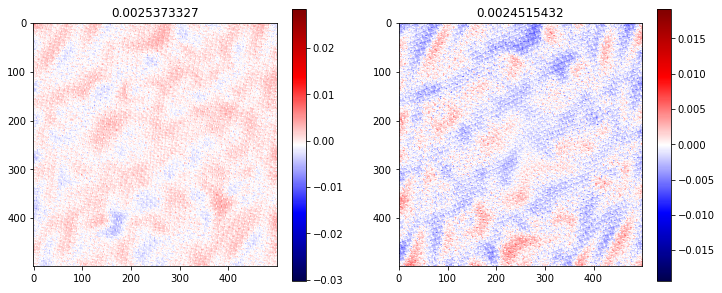

In [37]:
u,v = optical_flow_tvl1(deformed_ori, uc_averaged_uori, attachment=0.001, tightness=0.2, num_iter=20)
fi, ax = plt.subplots(ncols=2, figsize=[12,5])
im = ax[0].imshow(u.T, cmap='seismic')
ax[0].set_title(np.abs(u).mean())
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(v.T, cmap='seismic')
ax[1].set_title(np.abs(v).mean())
plt.colorbar(im, ax=ax[1])